In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [ ]:
def process_label(input):
    y = []
    for i in input:
        y.append([0 for _ in range(10)])
        y[-1][i] = 1
    return np.array(y)

In [ ]:
def get_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    print(x_train.shape)
    x_original_train = x_train.reshape(60000,784).astype('float64')
    x_original_test = x_test.reshape(10000,784).astype('float64')
    x_train = x_original_train.copy()
    x_test = x_original_test.copy()
    x_train -= np.mean(x_train, axis = 0)
    x_train /= np.std(x_train, axis = 0)
    x_test -= np.mean(x_test, axis = 0)
    x_test /= np.std(x_test, axis = 0)
    y_train = process_label(y_train)
    y_test = process_label(y_test)
    return x_train, y_train, x_test, y_test, x_original_train, x_original_test
x_train, y_train, x_test, y_test, x_ori_train, x_ori_test = get_data()


(60000, 28, 28)


In [ ]:
"""
define the activation function
"""
ReLU = lambda z : np.maximum(z, 0)
tanh = lambda z : np.tanh(z)
Leaky_ReLU = lambda z : np.maximum(z, 0) + 0.01*np.minimum(0,z)
l1_penalty = lambda z : np.sum(np.abs(z))
ReLU_l1 = lambda z : ReLU(z) + 0.5*l1_penalty(z) 



def softmax(z):
  #print(z.shape,"lalala")
  for idx, col in enumerate(z):
    sum = 0
    for element in col:
      sum += np.exp(element)
    #for idx1, element in col:
    count=0
    for element in col:
      z[idx][count] = np.exp(element)/sum
      count=count+1
  return z

"""
define the derivative 
"""
def derivative(z,function):
  if function == ReLU:
    dev = []
    for idx in range(len(z)):
      data = [1 if value>0 else 0 for value in z[idx]]
      dev.append(data)
    return dev
  elif function == ReLU_l1:
    dev = []
    for idx in range(len(z)):
      data = [1.5 if value>0 else 0.5 for value in z[idx]]
      dev.append(data)
    return dev
  elif function == tanh:
    return 1.0 - np.tanh(z) * np.tanh(z)
  elif function == Leaky_ReLU:
    dev = []
    for idx in range(len(z)):
      data = [1 if value>0 else 0.01 for value in z[idx]]
      dev.append(data)
    return dev

a = derivative([[1,1],[-1,-1]],Leaky_ReLU)
print(a)

[[1, 1], [0.01, 0.01]]


In [ ]:
class MLP:
  def __init__(self, M = 128, num_of_hidden_layers = 1, activation_fn = ReLU, batch_number = 0, lambdaa = 0):
    self.M = M
    self.num_of_hidden_layers = num_of_hidden_layers
    self.activation_fn = activation_fn
    self.batch_number = batch_number
    self.lambdaa = lambdaa
  
  def fit(self, x, y, optimizer):
    N,D = x.shape
    if self.batch_number > 0:
      N = self.batch_number
    def gradient_with_zero_hidden_layers(x, y, params):
      w = params[0]
      yh = softmax(np.dot(x, w))
      dy = yh - y
      dw = np.dot(x.T, dy)/N
      if self.lambdaa != 0:
        for i in range(len([dw])):
          [dw][i] += self.lambdaa * [w][i]
      return [dw]

    def gradient_with_one_hidden_layers(x, y, params):
      v, w = params
      z = self.activation_fn(np.dot(x, v)) #N x M
      yh = softmax(np.dot(z, w)) #N
      dy = yh - y #N
      dw = np.dot(z.T, dy)/N #M
      dz = np.dot(dy, w.T) #N x M
      dv = np.dot(x.T, dz * derivative(z,self.activation_fn))/N #D x M
      if self.lambdaa != 0:
        for i in range(len([dv,dw])):
          [dv,dw][i] += self.lambdaa * params[i]
      new_params = [dv, dw]
      return new_params
    
    def gradient_with_two_hidden_layers(x,y,params):
      v, k, w = params
      z1 = self.activation_fn(np.dot(x, v))
      z2 = self.activation_fn(np.dot(z1, k))
      yh = softmax(np.dot(z2, w))
      dy = yh - y
      dw = np.dot(z2.T, dy)/N
      dz2 = np.dot(dy,w.T)
      dk = np.dot(z1.T, dz2 * derivative(z2, self.activation_fn)) / N
      dz1 = np.dot(dz2, k.T)
      dv = np.dot(x.T, dz1 * derivative(z1, self.activation_fn)) / N
      if self.lambdaa != 0:
        for i in range(len([dv,dk,dw])):
          [dv,dk,dw][i] += self.lambdaa * params[i]
      new_params = [dv,dk,dw]
      return new_params

    if self.num_of_hidden_layers == 0:
      w = np.random.randn(784,10) * .01
      self.params = optimizer.run(gradient_with_zero_hidden_layers, x, y, [w],self.batch_number,self.activation_fn)
      return self

    if self.num_of_hidden_layers == 1:
      w = np.random.randn(self.M, 10) * .01
      v = np.random.randn(D,self.M) * .01
      params0 = [v,w]
      self.params = optimizer.run(gradient_with_one_hidden_layers, x, y, params0,self.batch_number,self.activation_fn)
      return self

    if self.num_of_hidden_layers == 2:
      w = np.random.randn(self.M, 10) * .01
      k = np.random.randn(self.M, self.M) * .01
      v = np.random.randn(D,self.M) * .01
      params0 = [v,k,w]
      self.params = optimizer.run(gradient_with_two_hidden_layers, x, y, params0,self.batch_number,self.activation_fn)
      return self
  
  def predict(self, x):
    yh = x.copy()
    for i,matrix in enumerate(self.params):
      yh = np.dot(yh,matrix)
      if i == len(self.params)-1:
        yh = softmax(yh)
      else:
        yh = self.activation_fn(yh) 
    return yh

In [ ]:
class GradientDescent():
  def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
    self.learning_rate = learning_rate
    self.max_iters = max_iters
    self.epsilon = epsilon

  def run(self, gradient_fn, x, y, params, batch_number = 0,activation_fn=ReLU):
    train_acc = []
    test_acc = []
    num_of_iter = []
    norms = np.array([np.inf])
    def get_predict_acc(params,x,y):
      yh = x.copy()
      for i,matrix in enumerate(params):
        yh = np.dot(yh,matrix)
        if i == len(params)-1:
          yh = softmax(yh)
        else:
          yh = activation_fn(yh)
      return evaluate_acc(yh,y) 
    t = 1
    while np.any(norms > self.epsilon) and t < self.max_iters:
      if batch_number != 0:
        inds = np.random.permutation(len(x))
        x = np.array(x)[inds]
        y = y[inds]
        num = len(x) // batch_number
        for i in range(num):
          batch_x = x[i * batch_number : (i+1) * batch_number]
          batch_y = y[i * batch_number : (i+1) * batch_number]
          grad = gradient_fn(batch_x, batch_y, params)
          for p in range(len(params)):
            params[p] -= self.learning_rate * grad[p]
          norms = np.array([np.linalg.norm(g) for g in grad])
      else:
        grad = gradient_fn(x, y, params)
        for p in range(len(params)):
          params[p] -= self.learning_rate * grad[p]
        norms = np.array([np.linalg.norm(g) for g in grad])
      if (t % 5 == 0):
        num_of_iter.append(t)
        train_acc.append(get_predict_acc(params,x_train,y_train))
        test_acc.append(get_predict_acc(params,x_test,y_test))
      t +=1
      print(t,"num")
    plt.plot(num_of_iter,train_acc,label="Training accuracy")
    plt.plot(num_of_iter,test_acc,label="Testing accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    return params


In [ ]:
def evaluate_acc(prediction,y_test):
  num_of_correct = 0
  for i in range(len(prediction)):
    lst = prediction[i].tolist()
    #print(lst)
    idx1 = lst.index(max(lst))
    idx2 = y_test[i].tolist().index(max(y_test[i].tolist()))
    if idx1 == idx2:
      num_of_correct +=1
  return num_of_correct/len(y_test)

Task 3.5


In [ ]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)), 
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.summary

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

(x_train_cnn, y_train_cnn), (x_test_cnn, y_test_cnn) = keras.datasets.fashion_mnist.load_data()

train_images = x_train_cnn / 255.0

test_images = x_test_cnn / 255.0

model.fit(x_train_cnn, y_train_cnn, epochs=10)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 100s 53ms/step - loss: 1.1515 - accuracy: 0.7104
Epoch 2/10
1875/1875 [==============================] - 97s 52ms/step - loss: 0.5277 - accuracy: 0.8084
Epoch 3/10
1875/1875 [==============================] - 102s 55ms/step - loss: 0.4672 - accuracy: 0.8280
Epoch 4/10
1875/1875 [==============================] - 102s 54ms/step - loss: 0.4283 - accuracy: 0.8435
Epoch 5/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.4040 - accuracy: 0.8508
Epoch 6/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.3807 - accuracy: 0.8597
Epoch 7/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.3689 - accuracy: 0.8639
Epoch 8/10
1875/1875 [==============================] - 102s 54ms/step - loss: 0.3629 - accuracy: 0.8664
Epoch 9/10
1875/1875 [==============================] - 103s 55ms/step - loss: 0.3578 - accuracy: 0.8702
Epoch 10/10
1875/1875 [==============================] - 103s 55ms/

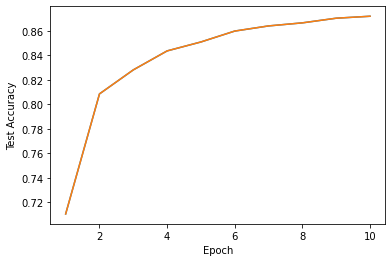

In [ ]:
acc=[]
epoch=[]
acc.extend([0.7104,0.8084,0.8280,0.8435,0.8508,0.8597,0.8639,0.8664,0.8702,0.8718])
epoch.extend([1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.plot(epoch, acc)
line1 = plt.plot(epoch, acc, label='epoch')
plt.show()

3.1

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num
31 num
32 num
33 num
34 num
35 num
36 num
37 num
38 num
39 num
40 num
41 num
42 num
43 num
44 num
45 num
46 num
47 num
48 num
49 num
50 num
51 num
52 num
53 num
54 num
55 num
56 num
57 num
58 num
59 num
60 num
61 num
62 num
63 num
64 num
65 num
66 num
67 num
68 num
69 num
70 num
71 num
72 num
73 num
74 num
75 num
76 num
77 num
78 num
79 num
80 num
81 num
82 num
83 num
84 num
85 num
86 num
87 num
88 num
89 num
90 num
91 num
92 num
93 num
94 num
95 num
96 num
97 num
98 num
99 num
100 num


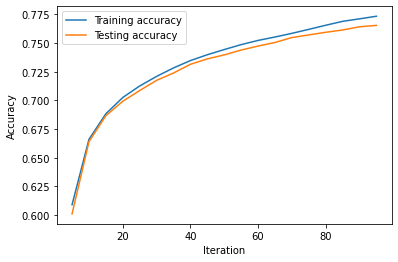

0.7664

In [ ]:
model1 = MLP(num_of_hidden_layers = 0)
optimizer = GradientDescent(learning_rate=.01, max_iters=100)
yh = model1.fit(x_train, y_train, optimizer).predict(x_test)
evaluate_acc(yh,y_test)


2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num
31 num
32 num
33 num
34 num
35 num
36 num
37 num
38 num
39 num
40 num
41 num
42 num
43 num
44 num
45 num
46 num
47 num
48 num
49 num
50 num
51 num
52 num
53 num
54 num
55 num
56 num
57 num
58 num
59 num
60 num
61 num
62 num
63 num
64 num
65 num
66 num
67 num
68 num
69 num
70 num
71 num
72 num
73 num
74 num
75 num
76 num
77 num
78 num
79 num
80 num
81 num
82 num
83 num
84 num
85 num
86 num
87 num
88 num
89 num
90 num
91 num
92 num
93 num
94 num
95 num
96 num
97 num
98 num
99 num
100 num


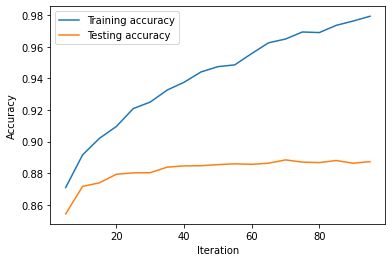

0.8863

In [ ]:
model2 = MLP(num_of_hidden_layers = 1,batch_number=50)
optimizer = GradientDescent(learning_rate=.01, max_iters=100)
yh = model2.fit(x_train, y_train, optimizer).predict(x_test)
evaluate_acc(yh,y_test)

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num
31 num
32 num
33 num
34 num
35 num
36 num
37 num
38 num
39 num
40 num
41 num
42 num
43 num
44 num
45 num
46 num
47 num
48 num
49 num
50 num
51 num
52 num
53 num
54 num
55 num
56 num
57 num
58 num
59 num
60 num
61 num
62 num
63 num
64 num
65 num
66 num
67 num
68 num
69 num
70 num
71 num
72 num
73 num
74 num
75 num
76 num
77 num
78 num
79 num
80 num
81 num
82 num
83 num
84 num
85 num
86 num
87 num
88 num
89 num
90 num
91 num
92 num
93 num
94 num
95 num
96 num
97 num
98 num
99 num
100 num


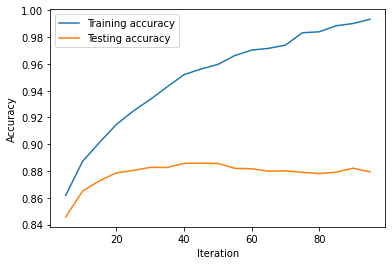

0.881

In [ ]:
model3 = MLP(num_of_hidden_layers = 2,batch_number = 50)
optimizer = GradientDescent(learning_rate=.01, max_iters=100)
yh = model3.fit(x_train, y_train, optimizer).predict(x_test)
evaluate_acc(yh,y_test)

3.2

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num
31 num
32 num
33 num
34 num
35 num
36 num
37 num
38 num
39 num
40 num
41 num
42 num
43 num
44 num
45 num
46 num
47 num
48 num
49 num
50 num
51 num
52 num
53 num
54 num
55 num
56 num
57 num
58 num
59 num
60 num
61 num
62 num
63 num
64 num
65 num
66 num
67 num
68 num
69 num
70 num
71 num
72 num
73 num
74 num
75 num
76 num
77 num
78 num
79 num
80 num
81 num
82 num
83 num
84 num
85 num
86 num
87 num
88 num
89 num
90 num
91 num
92 num
93 num
94 num
95 num
96 num
97 num
98 num
99 num
100 num


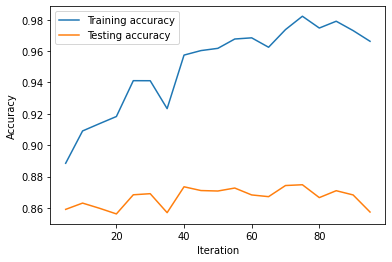

0.866

In [ ]:
model3_2_1 = MLP(num_of_hidden_layers = 2, activation_fn = tanh,batch_number=50)
optimizer = GradientDescent(learning_rate=.01, max_iters=100)
yh = model3_2_1.fit(x_train, y_train, optimizer).predict(x_test)
evaluate_acc(yh,y_test)


2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num
31 num
32 num
33 num
34 num
35 num
36 num
37 num
38 num
39 num
40 num
41 num
42 num
43 num
44 num
45 num
46 num
47 num
48 num
49 num
50 num
51 num
52 num
53 num
54 num
55 num
56 num
57 num
58 num
59 num
60 num
61 num
62 num
63 num
64 num
65 num
66 num
67 num
68 num
69 num
70 num
71 num
72 num
73 num
74 num
75 num
76 num
77 num
78 num
79 num
80 num
81 num
82 num
83 num
84 num
85 num
86 num
87 num
88 num
89 num
90 num
91 num
92 num


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


93 num


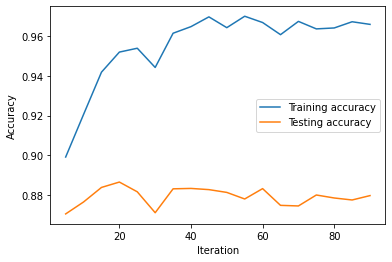

0.1

In [ ]:
model3_2_2 = MLP(num_of_hidden_layers = 2, activation_fn = Leaky_ReLU,batch_number=50)
optimizer = GradientDescent(learning_rate=.01, max_iters=100)
yh = model3_2_2.fit(x_train, y_train, optimizer).predict(x_test)
evaluate_acc(yh,y_test)

3.3

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num
31 num
32 num
33 num
34 num
35 num
36 num
37 num
38 num
39 num
40 num
41 num
42 num
43 num
44 num
45 num
46 num
47 num
48 num
49 num
50 num
51 num
52 num
53 num
54 num
55 num
56 num
57 num
58 num
59 num
60 num
61 num
62 num
63 num
64 num
65 num
66 num
67 num
68 num
69 num
70 num
71 num
72 num
73 num
74 num
75 num
76 num
77 num
78 num
79 num
80 num
81 num
82 num
83 num
84 num
85 num
86 num
87 num
88 num
89 num
90 num
91 num
92 num
93 num
94 num
95 num
96 num
97 num
98 num
99 num
100 num


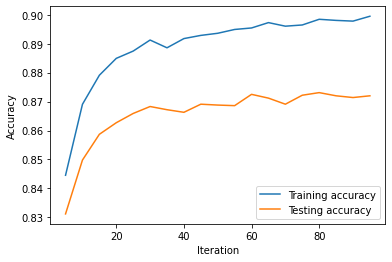

0.8731

In [ ]:
model3_3 = MLP(num_of_hidden_layers = 2, activation_fn = ReLU,lambdaa = 0.01,batch_number=50)
optimizer = GradientDescent(learning_rate=.01, max_iters=100)
yh = model3_3.fit(x_train, y_train, optimizer).predict(x_test)
evaluate_acc(yh,y_test)

3.4

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num
31 num
32 num
33 num
34 num
35 num
36 num
37 num
38 num
39 num
40 num
41 num
42 num
43 num
44 num
45 num
46 num
47 num
48 num
49 num
50 num
51 num
52 num
53 num
54 num
55 num
56 num
57 num
58 num
59 num
60 num
61 num
62 num
63 num
64 num
65 num
66 num
67 num
68 num
69 num
70 num
71 num
72 num
73 num
74 num
75 num
76 num
77 num
78 num
79 num
80 num
81 num
82 num
83 num
84 num
85 num
86 num
87 num
88 num
89 num
90 num
91 num
92 num
93 num
94 num
95 num
96 num
97 num
98 num
99 num
100 num


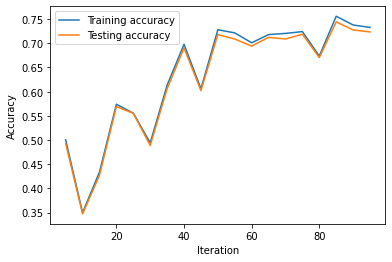

0.7553

In [ ]:
model3_4 = MLP(num_of_hidden_layers = 2, activation_fn = ReLU)
optimizer = GradientDescent(learning_rate=.01, max_iters=100)
yh = model3_4.fit(x_ori_train, y_train, optimizer).predict(x_ori_test)
evaluate_acc(yh,y_test)

Task 3.6

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


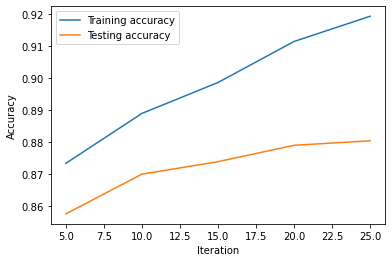

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


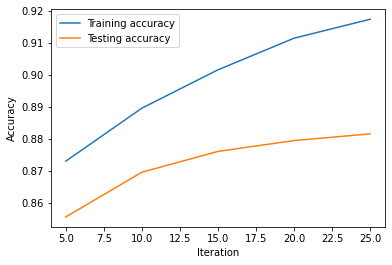

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


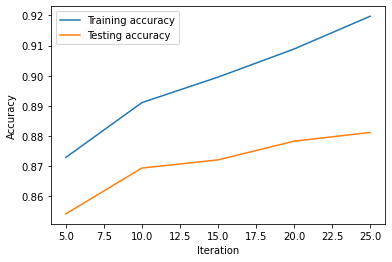

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


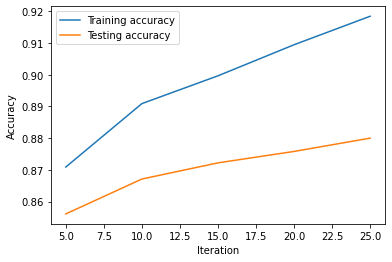

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


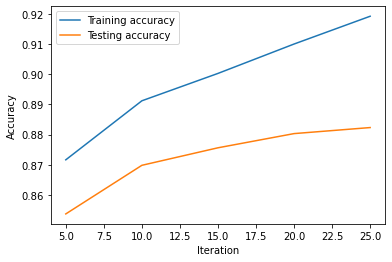

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


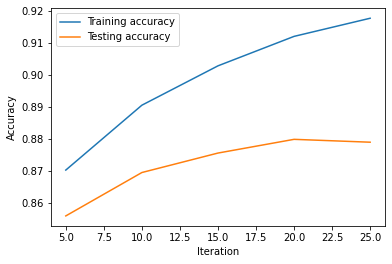

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


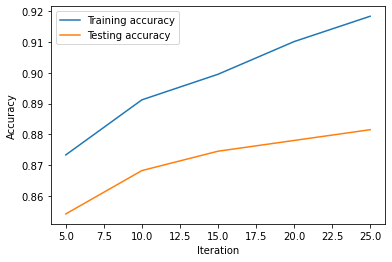

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


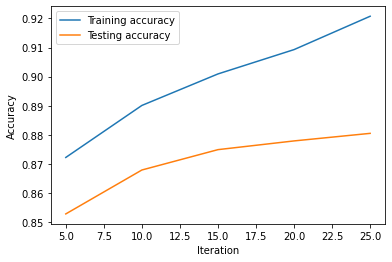

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


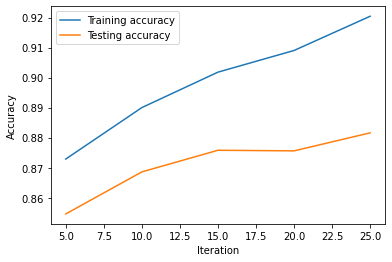

2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


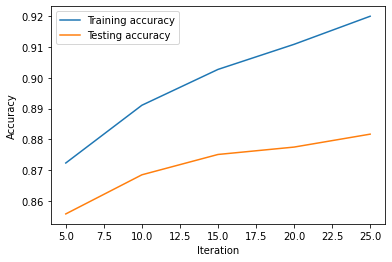

In [ ]:
rate=0.01
while(rate < 0.1):
  model2 = MLP(num_of_hidden_layers = 1, batch_number=50)
  optimizer = GradientDescent(learning_rate=0.01, max_iters=30)
  yh = model2.fit(x_train, y_train, optimizer).predict(x_test)
  evaluate_acc(yh,y_test)
  rate+=0.01



2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


22 num


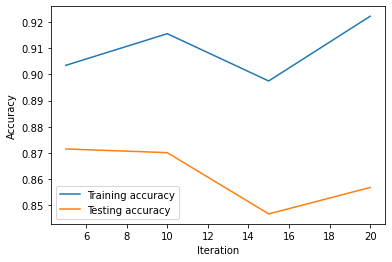

0.1
2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


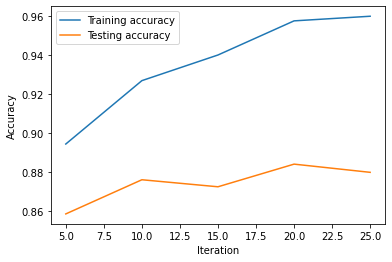

0.879
2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


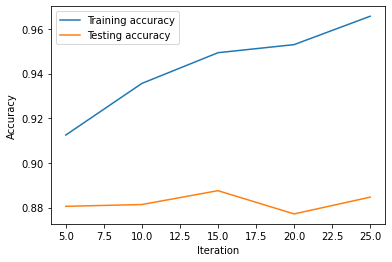

0.886
2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


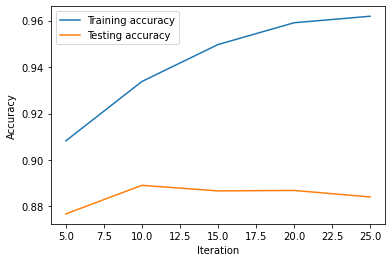

0.8827
2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


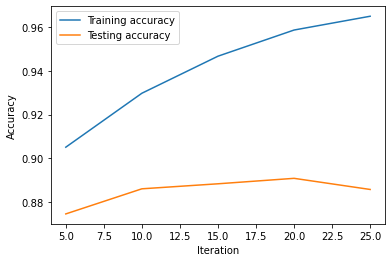

0.88
2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


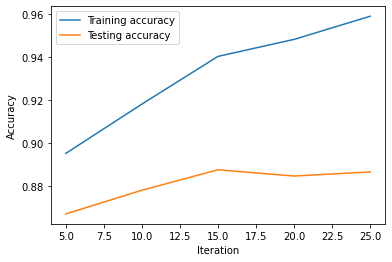

0.8874
2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


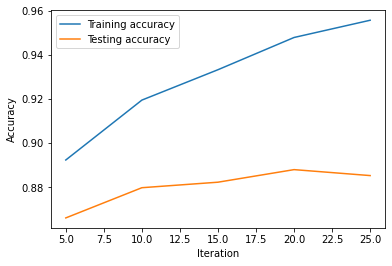

0.8877
2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


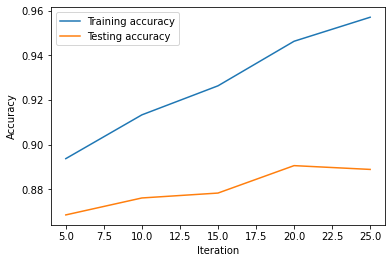

0.8869
2 num
3 num
4 num
5 num
6 num
7 num
8 num
9 num
10 num
11 num
12 num
13 num
14 num
15 num
16 num
17 num
18 num
19 num
20 num
21 num
22 num
23 num
24 num
25 num
26 num
27 num
28 num
29 num
30 num


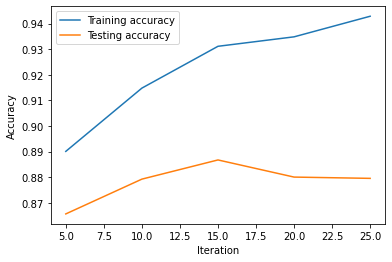

0.8852


In [ ]:
batch=10
while(batch < 100):
  model2 = MLP(num_of_hidden_layers = 1, batch_number=batch)
  optimizer = GradientDescent(learning_rate=0.05, max_iters=30)
  yh = model2.fit(x_train, y_train, optimizer).predict(x_test)
  print(evaluate_acc(yh,y_test))
  batch+=10